# Introduction #

In this exercise, you'll practice using add *dropout* and *batch normalization*.

Run the next cell to get started!

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [4]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

# TODO: Use 'make_column_transformer' to scale and encode columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()


preprocessor = make_column_transformer((numerical_transformer, features_num), (categorical_transformer, features_cat))

A custom function to split the dataset into training and validation sets, taking into account the grouping by artists to prevent data leakage.

In [5]:
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [6]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


# 1) Add Dropout to Spotify Model

Add two dropout layers in a new model, one after the Dense layer with 128 units, and one after the Dense layer with 64 units. Set the dropout rate on both to 0.3.

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# YOUR CODE HERE: Create new model `model_2`. Add two 30% dropout layers, one after 128 and one after 64
model_2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

Now run this next cell to train both models and see the effect of adding dropout.



Minimum Validation Loss (No Dropout): 0.1941
Minimum Validation Loss (30% Dropout): 0.1885


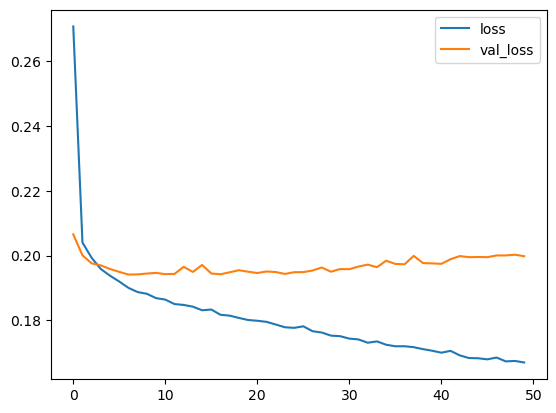

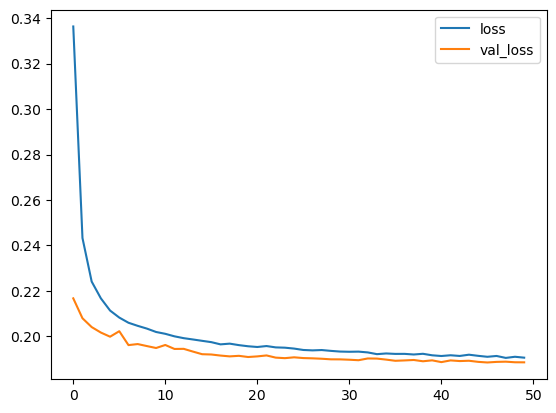

In [8]:
# no dropout
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss (No Dropout): {:0.4f}".format(history_df['val_loss'].min()))

# with dropout
model_2.compile(
    optimizer='adam',
    loss='mae',
)
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss (30% Dropout): {:0.4f}".format(history_df['val_loss'].min()))

In [16]:
history.history

{'loss': [35.53282165527344,
  35.16099166870117,
  34.76911544799805,
  34.341529846191406,
  33.863861083984375,
  33.30725860595703,
  32.65339660644531,
  31.869869232177734,
  30.922012329101562,
  29.773590087890625,
  28.344308853149414,
  26.59166717529297,
  24.432382583618164,
  21.687381744384766,
  18.619157791137695,
  15.478282928466797,
  12.596238136291504,
  10.431861877441406,
  8.950824737548828,
  7.169222354888916,
  6.602020263671875,
  6.953513145446777,
  6.566452980041504,
  6.019983768463135,
  5.38957405090332,
  5.856910705566406,
  5.72639274597168,
  6.581918239593506,
  5.644898414611816,
  5.498885631561279,
  5.240117073059082,
  5.622454643249512,
  4.976694583892822,
  4.99245548248291,
  4.807226657867432,
  4.730734825134277,
  5.1876068115234375,
  5.458390712738037,
  4.667770862579346,
  4.724462509155273,
  4.836223602294922,
  5.1119465827941895,
  4.993076801300049,
  4.868346691131592,
  4.777772903442383,
  4.482203483581543,
  4.62546396255

# 2) Try Batch Normalization

In [9]:
concrete = pd.read_csv('concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Run the following cell to train the network on the unstandardized *Concrete* data.


Minimum Validation Loss: 427.9954


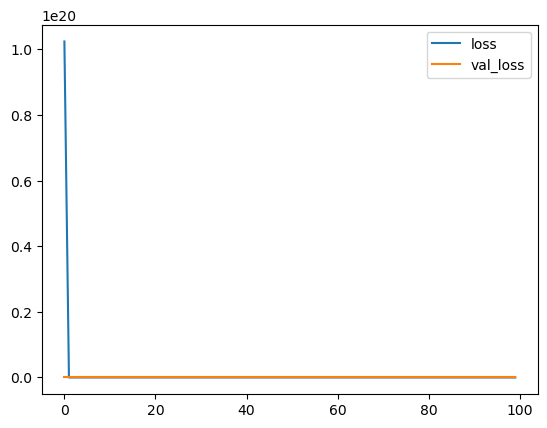

In [10]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did you end up with a blank graph? Trying to train this network on this dataset will usually fail. Even when it does converge (due to a lucky weight initialization), it tends to converge to a very large number.

Batch normalization can help correct problems like this.

Add four `BatchNormalization` layers, one before each of the dense layers. (Remember to move the `input_shape` argument to the new first layer.)

In [11]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

Run the next cell to see if batch normalization will let us train the model.

Minimum Validation Loss: 5.1088


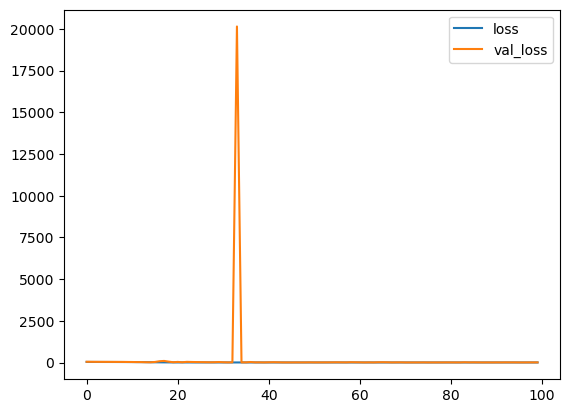

In [12]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

Did adding batch normalization help?